# Exercise 2: LSTMs for Urban Demand Prediction

In this exercise, we are considering rideshare demand for the city of Austin, TX, USA.  

The city is divided into a 27X27 grid.  For each region, we have a timeseries of rides taken for a particular time period. 

For this exercise, we will train an independent LSTM model for each grid cell.  This approach ignores all spatial correlations in the demand, but it allows us to train a model for one region in a short time, which makes it useful for a class exercise.

First import the usual libraries

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
%matplotlib inline

Read in the csv file that provides the gridded timeseries of rides taken in Austin, TX, USA from August 1, 2016 to April 13, 2017.  You may need to adjust the file path depending on your environment.

In [6]:
file_location = '../rideaustin/rideaustin_grided_hourly_2000_20160801-20170413.csv'
hourly_grid_timeseries = pd.read_csv(file_location, index_col = 0)
hourly_grid_timeseries.index = pd.to_datetime(hourly_grid_timeseries.index)
hourly_grid_timeseries.shape

(6144, 784)

Select the timeseries for particular region.  Each region is indexed by a string coordinate tag of the form "x_y"

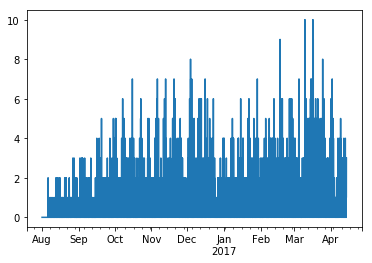

In [95]:
sample_data = hourly_grid_timeseries['9_16'] #try 9_16, 9_17, 8_16, 8_17
sample_data.plot()

## Question 1

Use the hourly_grid_timeseries data frame to find the the 3 regions 
with the highest total rides across the whole timeseries.

This should only take a few lines of code.

Check that your answers make sense by plotting the timeseries for each of the 5 regions.  You can just change the code in the previous cell and inspect the plot; no need to turn in the plots.

Plot a heatmap showing the rides across the whole city for a particular timestep

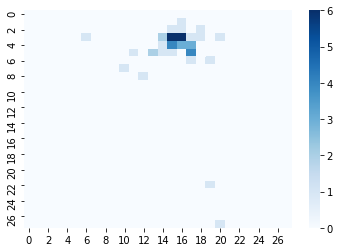

In [104]:
import seaborn as sbn
data = hourly_grid_timeseries
row = data.loc['2016-11-12 11:00:00']
ijv = [x.split('_') + [row[x]] for x in row.keys()]
dd = dict()
for i, j, v in ijv:
    dd.setdefault(int(j), []).append(v)
df = pd.DataFrame(dd)
df = df.reindex(sorted(df.columns))
ax = sbn.heatmap(df, cmap="Blues")

## Question 2

Find the two busiest hours of the day across the whole city. 

You can use `pd.DatetimeIndex(hourly_grid_timeseries.index).hour` to extract the hours.  Then compute the average ride count by hour (i.e., group by hour), and report the top two.



Set up data preparation and training

In [25]:
TIMESTEPS = 168 # one week
RNN_LAYERS = [{'steps': TIMESTEPS}]
TRAINING_STEPS = 500
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100
N_HIDDEN = 30

In [26]:
class generateData(object):
    '''Prepares data for training, and delivers batches during training'''
    def __init__(self, rawdata, timesteps, batchsize):
        self.timesteps = timesteps
        self.batchsize = batchsize
        self.rawdata = rawdata
        self.train_batch_id = 0
        self.test_batch_id = 0
        
        self.X, self.y = self.load_csvdata()
        self.train_x = self.X['train']
        self.train_y = self.y['train']
        self.val_x = self.X['val']
        self.val_y = self.y['val']
        self.test_x = self.X['test']
        self.test_y = self.y['test']
        
        

    def rnn_data(self, data, labels=False):
        """
        creates new data frame based on previous observation
          * example:
            l = [1, 2, 3, 4, 5]
            time_steps = 2
            -> labels == False [[1, 2], [2, 3], [3, 4]] #Data frame for input with 2 timesteps
            -> labels == True [3, 4, 5] # labels for predicting the next timestep
        """
        rnn_df = []
        for i in range(len(data) - self.timesteps):
            if labels:
                try:
                    rnn_df.append(data.iloc[i + self.timesteps].values)
                except AttributeError:
                    rnn_df.append(data.iloc[i + self.timesteps])
            else:
                data_ = data.iloc[i: i + self.timesteps].values
                rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])

        return np.array(rnn_df, dtype=np.float32)


    def split_data(self, data, val_size=0.1, test_size=0.1):
        """
        splits data to training, validation and testing parts
        """
        ntest = int(round(len(data) * (1 - test_size)))
        nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

        df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]
        return df_train, df_val, df_test


    def prepare_data(self, data, labels=False, val_size=0.1, test_size=0.1):
        """
        Given the number of `time_steps` and some data,
        prepares training, validation and test data for an lstm cell.
        """
        df_train, df_val, df_test = self.split_data(data, val_size, test_size)
        return (self.rnn_data(df_train, labels=labels),
                self.rnn_data(df_val, labels=labels),
                self.rnn_data(df_test, labels=labels))

    # load raw data
    def load_csvdata(self):
        data = self.rawdata
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        # prep features
        train_x, val_x, test_x = self.prepare_data(data)
        # prep ground truth data
        train_y, val_y, test_y = self.prepare_data(data, labels=True)
        return dict(train=train_x, val=val_x, test=test_x), dict(train=train_y, val=val_y, test=test_y)
  
    # input train_x, train_y or test_x or test_y
    def train_next(self):
        """ Return a batch of data. When dataset end is reached, start over.
        """
        if self.train_batch_id == len(self.train_x):
            self.train_batch_id = 0
        batch_data = (self.train_x[self.train_batch_id:min(self.train_batch_id +
                                                  self.batchsize, len(self.train_x))])
        batch_labels = (self.train_y[self.train_batch_id:min(self.train_batch_id +
                                                  self.batchsize, len(self.train_y))])
#         batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id +
#                                                   self.batch_size, len(X))])
        self.train_batch_id = min(self.train_batch_id + self.batchsize, len(self.train_x))
        return batch_data, batch_labels
    
        # input train_x, train_y or test_x or test_y
    def test_next(self):
        """ Return a batch of data. When dataset end is reached, start over.
        """
        if self.test_batch_id == len(self.test_x):
            self.test_batch_id = 0
        batch_data = (self.test_x[self.test_batch_id:min(self.test_batch_id +
                                                  self.batchsize, len(self.test_x))])
        batch_labels = (self.test_y[self.test_batch_id:min(self.test_batch_id +
                                                  self.batchsize, len(self.test_y))])
        self.test_batch_id = min(self.test_batch_id + self.batchsize, len(self.test_x))
        return batch_data, batch_labels



In [27]:
data = generateData(sample_data, TIMESTEPS, BATCH_SIZE)

In [28]:
len(data.test_x)

446

Set up the network and training

In [126]:
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dynamic_rnn.ipynb

class SeriesPredictor:
    # input_dim = 1, seq_size = 168, hidden_dim = ?
    def __init__(self, input_dim, seq_size, hidden_dim):
        # Hyperparameters
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim

        # Weight variables and input placeholders
        self.W_out = tf.Variable(tf.random_normal([hidden_dim, 1]), name='W_out')
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        # modified y dimension, only need predict 1 y, not seq_size y
        self.y = tf.placeholder(tf.float32, [None, 1])

        # Cost optimizer
        self.cost = tf.reduce_mean(tf.square(self.model() - self.y))
        self.train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.cost)

        # Auxiliary ops
        self.saver = tf.train.Saver()

    def model(self):
        cell = tf.nn.rnn_cell.LSTMCell(self.hidden_dim, activation=tf.nn.relu)
        # num_examples = batch_size = 100
        num_examples = tf.shape(self.x)[0]
        outputs, states = tf.nn.dynamic_rnn(cell, self.x, dtype=tf.float32)
        print('shape of outputs: ', outputs.shape)

        # Hack to build the indexing and retrieve the right output.
        batch_size = tf.shape(outputs)[0]
        # Start indices for each sample
        index = tf.range(0, batch_size) * TIMESTEPS + (TIMESTEPS - 1)
        # Indexing
        outputs = tf.gather(tf.reshape(outputs, [-1, self.hidden_dim]), index)
        out = tf.matmul(outputs, self.W_out) + self.b_out
        print('shape of squeezed out: ', out.shape)
        # Linear activation, using outputs computed above
        return out
        
         

    def train(self, data):
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()
            sess.run(tf.global_variables_initializer())
            for i in range(TRAINING_STEPS):
                batch_x, batch_y = data.train_next()
                batch_test_x, batch_test_y = data.test_next()
                _, train_err = sess.run([self.train_op, self.cost], feed_dict={self.x: batch_x, self.y: batch_y})
                if i % 10 == 0:
                    test_err = sess.run(self.cost, feed_dict={self.x: batch_test_x, self.y: batch_test_y})
                    print('step: {}\t\ttrain err: {}\t\ttest err: {}'.format(i, train_err, test_err))
                                    
            save_path = self.saver.save(sess, './model.ckpt')
            print('Model saved to {}'.format(save_path))
     
    def test(self, sess, data):
        tf.get_variable_scope().reuse_variables()
        self.saver.restore(sess, './model.ckpt')
        output = sess.run(self.model(), feed_dict={self.x: data.test_x})
        return output

In [127]:
def plot_results(train_x, predictions, actual, filename):
    plt.figure()
    num_train = len(train_x)
    plt.plot(list(range(num_train)), train_x, color='b', label='training data')
    plt.plot(list(range(num_train, num_train + len(predictions))), predictions, color='r', label='predicted')
    plt.plot(list(range(num_train, num_train + len(actual))), actual, color='g', label='test data')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

Now we train the model. This step takes a few minutes.

In [128]:
tf.reset_default_graph()
predictor = SeriesPredictor(input_dim=1, seq_size=TIMESTEPS, hidden_dim=N_HIDDEN)    
data = generateData(sample_data, TIMESTEPS, BATCH_SIZE)
X, y = data.X, data.y
    
predictor.train(data)
print('finished training')


shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)


/Users/billhowe/miniconda3/envs/deep/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


step: 0		train err: 3.2977099418640137		test err: 1.5616596937179565
step: 10		train err: 1.2390391826629639		test err: 3.11151123046875
step: 20		train err: 1.0779300928115845		test err: 1.6796993017196655
step: 30		train err: 2.3801534175872803		test err: 1.3181933164596558
step: 40		train err: 2.358304738998413		test err: 1.2701983451843262
step: 50		train err: 1.9123364686965942		test err: 1.168837070465088
step: 60		train err: 0.958692193031311		test err: 1.0809760093688965
step: 70		train err: 2.8598504066467285		test err: 1.2326185703277588
step: 80		train err: 1.6980032920837402		test err: 0.9412794709205627
step: 90		train err: 1.8211668729782104		test err: 0.8921829462051392
step: 100		train err: 1.0126985311508179		test err: 0.8850033283233643
step: 110		train err: 1.0630016326904297		test err: 2.2679338455200195
step: 120		train err: 0.6918394565582275		test err: 0.8516546487808228
step: 130		train err: 1.315915584564209		test err: 0.86612868309021
step: 140		train err: 0.6

In [125]:

def mae(region):
    data = generateData(hourly_grid_timeseries[region], TIMESTEPS, BATCH_SIZE)

    sess = tf.Session()
    predicted_vals = predictor.test(sess, data)[:,0]
    #print('predicted_vals', np.shape(predicted_vals))

    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error


    predicted = np.transpose(predicted_vals)

    #rmse = np.sqrt((np.asarray((np.subtract(predicted, y['test']))) ** 2).mean()) 
    #score = mean_squared_error(predicted, y['test'])
    #nmse = score / np.var(y['test'])
    mae = mean_absolute_error(predicted, y['test'])
    #print("RSME: %f" % rmse)
    #print("NSME: %f" % nmse)
    #print("MSE: %f" % score)
    print(region, 'MAE: %f' %mae)
    return mae

maes = [mae(region) for region in hourly_grid_timeseries.keys()]

INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_0 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_1 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_10 MAE: 0.783183
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_11 MAE: 0.784327
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_12 MAE: 0.791124
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_13 MAE: 0.775135
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
0_14 MAE: 0.796642
INFO:tensorflow:Restoring parameters from .

11_11 MAE: 0.669395
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_12 MAE: 0.692349
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_13 MAE: 0.612528
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_14 MAE: 1.245699
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_15 MAE: 1.163674
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_16 MAE: 1.783350
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_17 MAE: 2.166336
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
11_18 MAE: 1.132518
INFO:tensorflo

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_15 MAE: 4.689314
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_16 MAE: 4.946214
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_17 MAE: 2.645411
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_18 MAE: 1.308067
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_19 MAE: 0.674141
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_2 MAE: 0.762622
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
13_20 MAE: 0.752226
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
sha

INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_19 MAE: 0.698472
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_2 MAE: 0.768064
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_20 MAE: 0.783416
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_21 MAE: 0.789312
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_22 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_23 MAE: 0.795164
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
15_24 MAE: 0.793554
INFO:tensorflow:Restoring parameter

17_21 MAE: 0.790738
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_22 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_23 MAE: 0.796850
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_24 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_25 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_26 MAE: 0.795709
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_27 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
17_3 MAE: 0.779549
INFO:tensorflow

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_25 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_26 MAE: 0.794587
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_27 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_3 MAE: 0.794086
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_4 MAE: 0.778931
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_5 MAE: 0.792534
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
19_6 MAE: 0.781907
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape 

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
20_4 MAE: 0.790125
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
20_5 MAE: 0.792581
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
20_6 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
20_7 MAE: 0.795063
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
20_8 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
20_9 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
21_0 MAE: 0.793169
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of 

INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
22_8 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
22_9 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
23_0 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
23_1 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
23_10 MAE: 0.791056
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
23_11 MAE: 0.792386
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
23_12 MAE: 0.795333
INFO:tensorflow:Restoring parameters f

25_1 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_10 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_11 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_12 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_13 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_14 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_15 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
25_16 MAE: 0.796751
INFO:tensorflow

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_13 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_14 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_15 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_16 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_17 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_18 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
27_19 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
sh

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_17 MAE: 0.788538
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_18 MAE: 0.784720
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_19 MAE: 0.795601
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_2 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_20 MAE: 0.794976
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_21 MAE: 0.795091
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
3_22 MAE: 0.796677
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of s

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_20 MAE: 0.743933
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_21 MAE: 0.793516
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_22 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_23 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_24 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_25 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
5_26 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of 

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_24 MAE: 0.795030
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_25 MAE: 0.789524
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_26 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_27 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_3 MAE: 0.781142
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_4 MAE: 0.778283
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
7_5 MAE: 0.782395
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squ

shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_3 MAE: 0.775908
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_4 MAE: 0.696401
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_5 MAE: 0.717867
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_6 MAE: 0.774392
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_7 MAE: 0.784042
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_8 MAE: 0.796751
INFO:tensorflow:Restoring parameters from ./model.ckpt
shape of outputs:  (?, 168, 30)
shape of squeezed out:  (?, 1)
9_9 MAE: 0.756275


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


predicted = np.transpose(predicted_vals)

rmse = np.sqrt((np.asarray((np.subtract(predicted, y['test']))) ** 2).mean()) 
score = mean_squared_error(predicted, y['test'])
nmse = score / np.var(y['test'])
mae = mean_absolute_error(predicted, y['test'])
print("RSME: %f" % rmse)
print("NSME: %f" % nmse)
print("MSE: %f" % score)
print('MAE: %f' %mae)


RSME: 1.377228
NSME: 0.642960
MSE: 0.873398
MAE: 0.588453


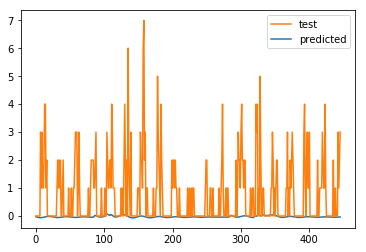

In [129]:
from matplotlib import pyplot as plt
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(y['test'], label='test')
plt.legend(handles=[plot_test, plot_predicted])


## Question 3

Train the model for each of the 3 regions you found in Question 1.  Report the MAE for each of the three regions.

## Question 4

For your best performing model associated with region X, evaluate the model trained on X on the test data from the other two regions.  You can construct a generateData object for each region, but use the test method of the SeriesPredictor class for your *trained* region X.  

Report the MAE of the model associated with region X on all three regions.  

Comment on the performance.  Is it feasible to train a model on one region and use it on another, as a simple instance of transfer learning?

## Question 5

Evaluate your best performing model associated with region X on the 8 regions neighboring X.  For example, if X is 8_17, evaluate on 7_16, 7_17, 7_19, 8_16, 8_19, 9_16, 9_17, 9_18.  Report the MAE for these neighboring regions. 

Does the model perform well on nearby regions, relative to your answers in question 4?  Why or why not?

## What to turn in
Report your answers on this google form: 
    https://forms.gle/RJUPbA1w6itaqA2R8